<h1 style="font-size:3rem;color:#3F778C; text-align:center;">Reto clustering</h1>


<h3 style="color:#6587A1; text-align:center;">Daniela Cortés Méndez<br>Sergio Andrés González Roa<br>Kareen Alejandra Latorre Martínez</h3>

# Imports

In [1]:
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np, numpy as np_test
from sklearn.impute import KNNImputer  
import pandas as pd,pandas as pd_test
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Importación de los datos

In [2]:
clients = pd.read_csv("./datos_de_clientes.csv", delimiter="\t")
clients.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Pre-procesamiento de los datos


In [3]:
current_year = datetime.datetime.now().year
clients['Age'] = current_year - clients['Year_Birth']

una linea

In [4]:
clients_education_encoded = pd.get_dummies(clients["Education"], prefix="Education", dtype=int)
clients = pd.concat([clients, clients_education_encoded], axis=1)

In [5]:
print(clients['Marital_Status'].value_counts())

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


In [6]:
marital_mode = str(clients['Marital_Status'].mode()[0])
print(f"mode: {marital_mode}")
clients['Marital_Status'] = clients['Marital_Status'].replace({'Alone': 'Single', 'Absurd': marital_mode, 'YOLO': marital_mode})
print(clients['Marital_Status'].value_counts())

mode: Married
Marital_Status
Married     868
Together    580
Single      483
Divorced    232
Widow        77
Name: count, dtype: int64


In [7]:
clients_marital_encoded = pd.get_dummies(clients["Marital_Status"], prefix="Marital_Status", dtype=int)
clients = pd.concat([clients, clients_marital_encoded], axis=1)

In [8]:
fill = KNNImputer(n_neighbors=1).fit_transform(clients[['Income']])
clients['Income'] = pd.DataFrame(fill, columns=['Income'])

In [9]:
clients['Days_Customer'] = (pd.to_datetime(datetime.datetime.now().strftime('%d-%m-%Y'), dayfirst=True) - pd.to_datetime(clients['Dt_Customer'], format='%d-%m-%Y')).dt.days

In [10]:
clients['Total_AcceptedCmp'] = clients['AcceptedCmp1'] + clients['AcceptedCmp2'] + clients['AcceptedCmp3'] + clients['AcceptedCmp4'] + clients['AcceptedCmp5'] + clients['Response']

In [11]:
clients['Total_SpentProducts'] = clients['MntWines'] + clients['MntFruits'] + clients['MntMeatProducts'] + clients['MntFishProducts'] + clients['MntSweetProducts'] + clients['MntGoldProds']

In [12]:
clients = clients.drop(["ID", "Year_Birth", "Education", "Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","Response"], axis=1) 
clients.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Days_Customer,Total_AcceptedCmp,Total_SpentProducts
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,4226,1,1617
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,3676,0,27
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,0,0,0,1,0,3875,0,776
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,0,0,0,0,1,0,3702,0,53
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,1,0,1,0,0,0,3724,0,422


## Eliminación de datos atípicos

boxplots

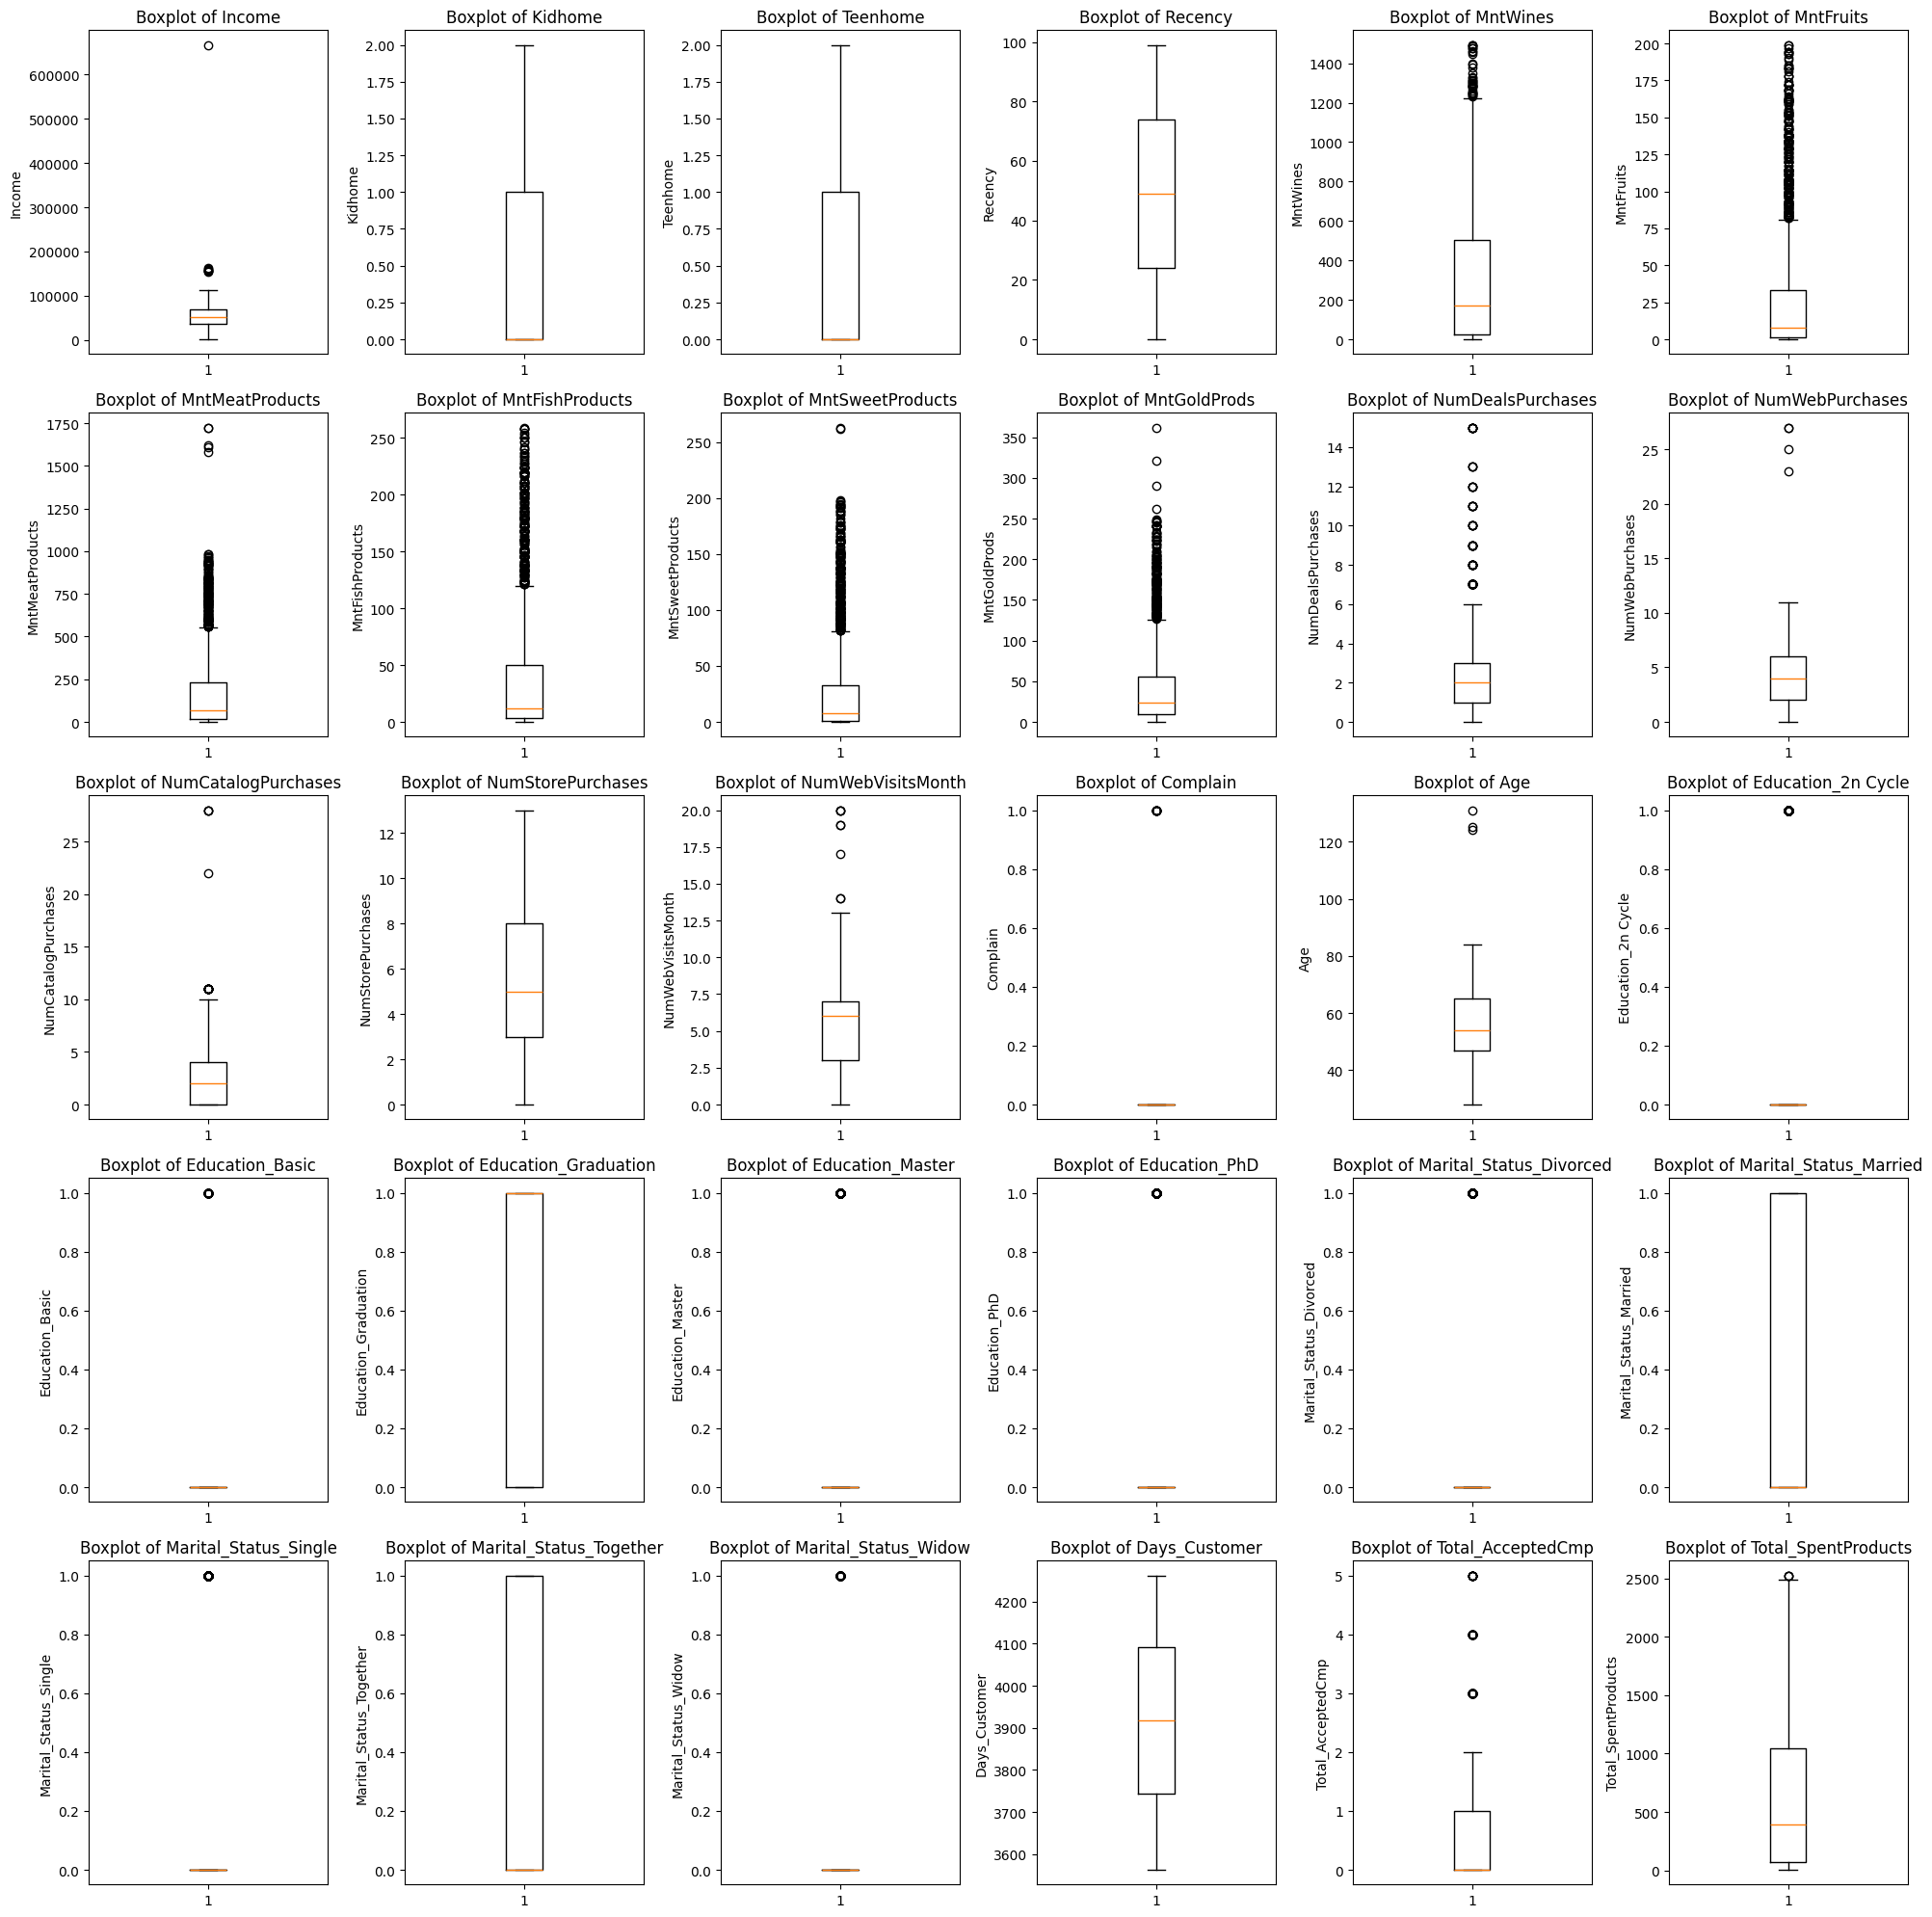

In [13]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(20, 20))
 
for i, column in enumerate(clients.columns):
    axs.flatten()[i].boxplot(clients[column])
    axs.flatten()[i].set_title(f'Boxplot of {column}')
    axs.flatten()[i].set_ylabel(column)
 
plt.tight_layout()
plt.show()


In [14]:
quantiles = np.quantile(clients['Income'], [0,0.25,0.5,0.75,1])
print(f'Quantiles: {quantiles}')

iqr = quantiles[3] - quantiles[1]
minimum_value = quantiles[1] - 1.5 * iqr
maximum_value = quantiles[3] + 1.5 * iqr

outlier_range = (minimum_value, maximum_value)
print(f'Range: {outlier_range}')

Quantiles: [  1730.    35538.75  51741.5   68289.75 666666.  ]
Range: (-13587.75, 117416.25)


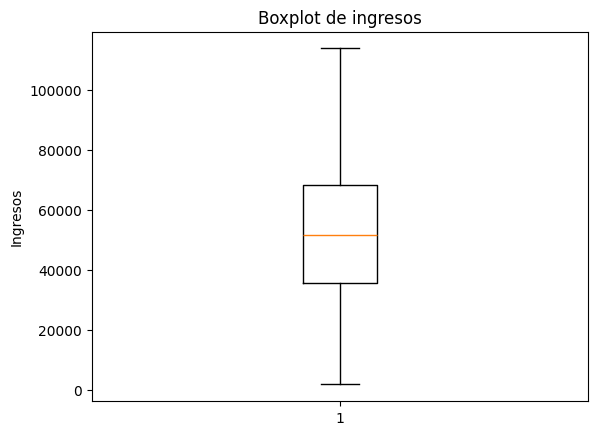

In [15]:
clients = clients[clients.Income < outlier_range[1]]

plt.title('Boxplot de ingresos')
plt.boxplot(clients['Income'])
plt.ylabel('Ingresos')
plt.show()

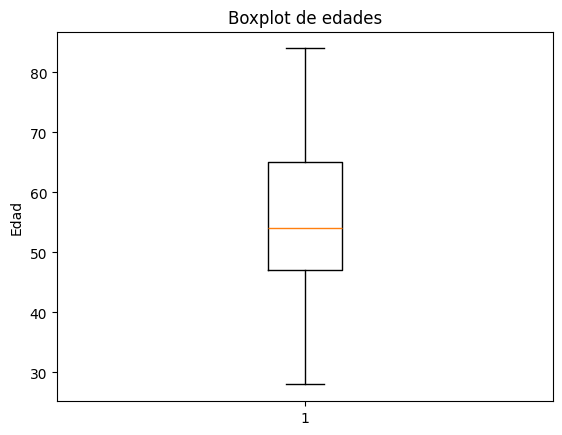

In [16]:
clients = clients[clients.Age < 100]

plt.title('Boxplot de edades')
plt.boxplot(clients['Age'])
plt.ylabel('Edad')
plt.show()

In [17]:
def kMeans(D, k, eps=0.01, mu=None, max_iter=20):
  d = D.shape[1]
  if mu is None:
    mu = np.random.rand(k, d) * (np.max(D, axis=0) - np.min(D, axis=0)) + np.min(D, axis=0)

  if type(mu) == list:
    mu = np.array(mu)

  s = False
  g = 0
  
  while not s:
    C = [np.argmin([np.linalg.norm(mu[j] - x) for j in range(k) if not any(np.isnan(mu[j]))]) for x in D]
    n = np.zeros(mu.shape)
    s = True
    for i in range(k):
      J = [D[j] for j in range(len(D)) if C[j] == i]
      if len(J) > 0:
        n[i] = np.mean(J, axis=0)
      else:
        n[i] = np.random.rand(1, d) * (np.max(D, axis=0) - np.min(D, axis=0)) + np.min(D, axis=0)
      if np.linalg.norm(mu[i] - n[i]) > eps:
        s = False
    mu = n
    g += 1
  return C, mu

def calculate_covariance_matrix(A, mu):
    n = A.shape[0]
    centered_data = A - mu
    covariance = np.dot(centered_data.T, centered_data) / n
    return covariance
 
total_v = 0
 
def PCA(D, red):
    global total_v
    cov_matrix = calculate_covariance_matrix(D, np.sum(D, axis=0) / D.shape[0])
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    descending_indices = np.argsort(eigenvalues)[::-1]
    descending_eigenvalues = eigenvalues[descending_indices]
    descending_eigenvectors = eigenvectors[:, descending_indices]
    total_v = np.real(np.sum(descending_eigenvalues))
   
    if red < 1:
        retained_variance = np.cumsum(descending_eigenvalues) / total_v
        r = np.argmax(retained_variance >= red) + 1
    elif isinstance(red, int):
        r = red
   
    A = np.dot(D, descending_eigenvectors[:, :r])
    v = np.real(np.sum(descending_eigenvalues[:r]))
    return A, v


 
    
def calculate_sse(A, C, mu):   
  errors = np.zeros(len(A))
  for i in range(len(A)):
    centroid = mu[C[i]]
    errors[i] = np.sum((A[i] - centroid) ** 2)
    sse = np.sum(errors)
  return sse

def getDistances(A):
  if type(A) is not np.ndarray:
      A = A.to_numpy()
     
  diff = A[:, np.newaxis, :] - A[np.newaxis, :, :]
  D = np.sqrt(np.sum(diff**2, axis=2))
  return D

def calculate_mean(A):
  return np.sum(A, axis=0) / A.shape[0]

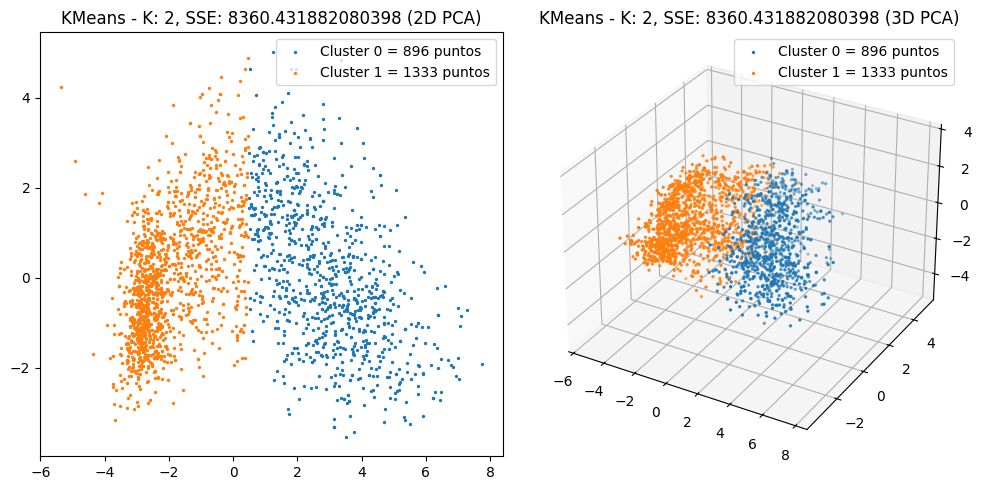

The best clustering for 2 clusters has an SSE value of 8360.431882080398


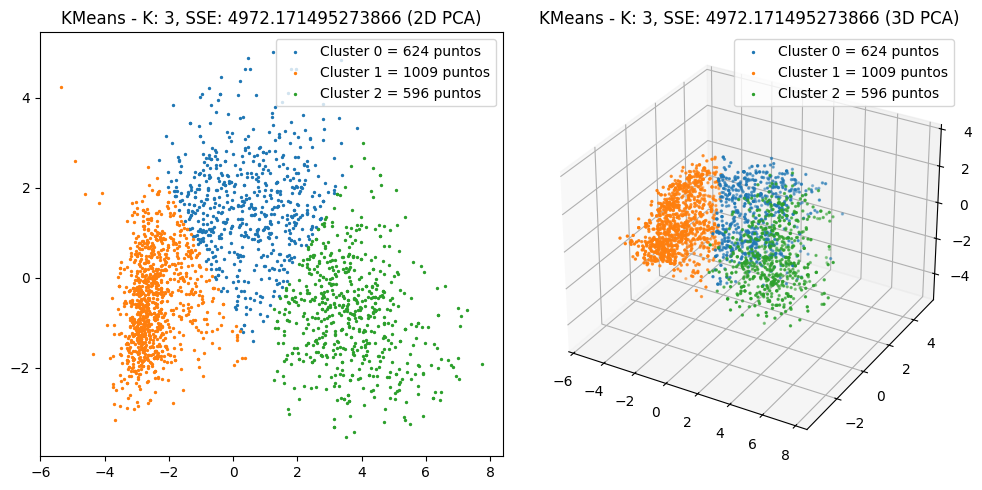

The best clustering for 3 clusters has an SSE value of 4972.171495273866


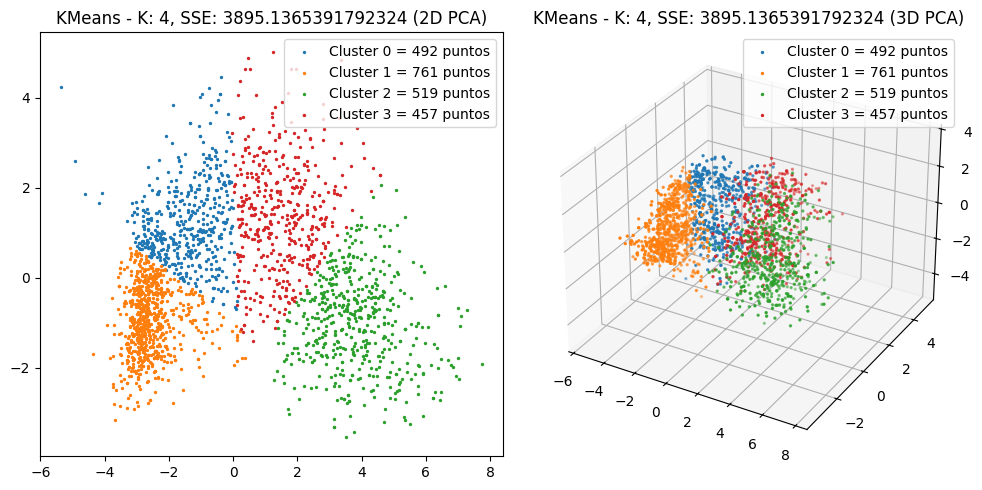

The best clustering for 4 clusters has an SSE value of 3895.1365391792324


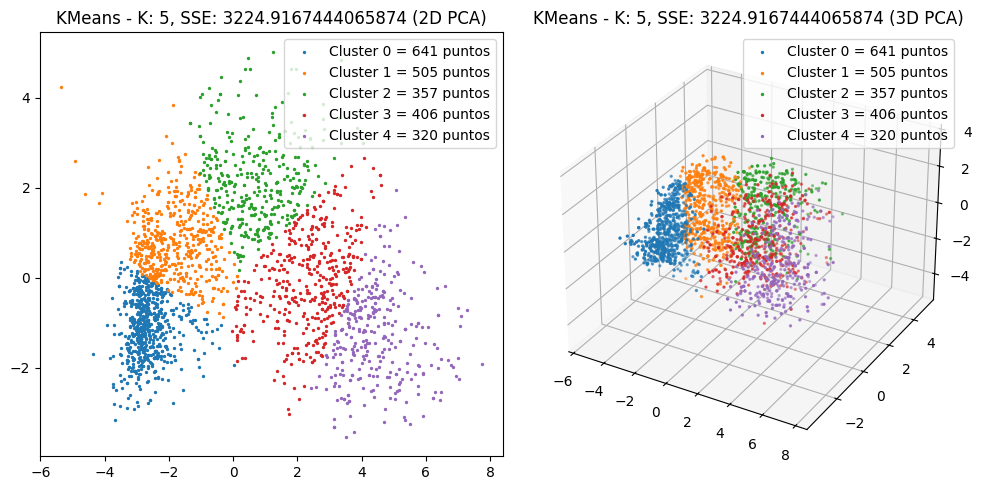

The best clustering for 5 clusters has an SSE value of 3224.9167444065874


In [18]:
df_normalized = pd.DataFrame(StandardScaler().fit_transform(clients), columns=clients.columns)
clients_2D, _ = PCA(df_normalized, 2) 
clients_3D, _ = PCA(df_normalized, 3)

kmeans_config = [2, 3, 4, 5]
num_iterations = 50

best_clusters_kmeans = [(np.inf, 0) for _ in kmeans_config]

for i, k in enumerate(kmeans_config):
    best_sse = np.inf
    best_clusters = 0

    for _ in range(num_iterations):
        clusters, centroids = kMeans(clients_2D, k)
        sse = calculate_sse(clients_2D, clusters, centroids)
        if sse < best_sse:
            best_sse = sse
            best_clusters = clusters
    best_clusters_kmeans[i] = (best_sse, best_clusters)  
    
    plt.figure(figsize=(10, 5))
    unique_clusters, counts = np.unique(best_clusters, return_counts=True)

    plt.subplot(1, 2, 1)
    for cluster_label in unique_clusters:
        cluster_mask = (best_clusters == cluster_label)
        plt.scatter(clients_2D[cluster_mask, 0], clients_2D[cluster_mask, 1], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=2)
    plt.title(f'KMeans - K: {k}, SSE: {best_sse} (2D PCA)')
    plt.legend()

    ax = plt.subplot(1, 2, 2, projection='3d')
    for cluster_label in unique_clusters:
        cluster_mask = (best_clusters == cluster_label)
        ax.scatter(clients_3D[cluster_mask, 0], clients_3D[cluster_mask, 1], clients_3D[cluster_mask, 2], label=f'Cluster {cluster_label} = {counts[cluster_label]} puntos', s=2)
    plt.title(f'KMeans - K: {k}, SSE: {best_sse} (3D PCA)')
    ax.legend()

    plt.tight_layout()
    plt.show()

    print(f"The best clustering for {k} clusters has an SSE value of {best_sse}")

## DBSCAN


In [19]:
def suggestedEpsilon(data, k):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
   
    distances = np.sort(distances, axis=0)[:, k-1]
   
    differences = np.diff(distances)
    knee_point = np.argmax(differences)
    suggested_epsilon = distances[knee_point]
   
    plt.plot(distances, label='Distancia al {} vecino más cercano'.format(k))
    plt.axhline(y=suggested_epsilon, color='r', linestyle='--', label='Punto de rodilla (eps sugerido aprox: {:.2f})'.format(suggested_epsilon))
    plt.ylabel('Distancia al {}-ésimo vecino más cercano'.format(k))
    plt.xlabel('Puntos ordenados')
    plt.title('Método rodilla para determinar eps en DBSCAN')
    plt.legend()
   
    return suggested_epsilon
  
def getEpsilons(k_values):
    epsilons = []
    for k in k_values:
        suggestedEpsilon(clients_2D, k)
        print(f"Para k={k}, el epsilon sugerido es: {suggestedEpsilon(clients_2D, k)}")
        epsilons.append(suggestedEpsilon(clients_2D, k))
    return epsilons

Para k=50, el epsilon sugerido es: 2.7592988134641625
Para k=40, el epsilon sugerido es: 2.6590326813499185
Para k=30, el epsilon sugerido es: 2.573251434092429


c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


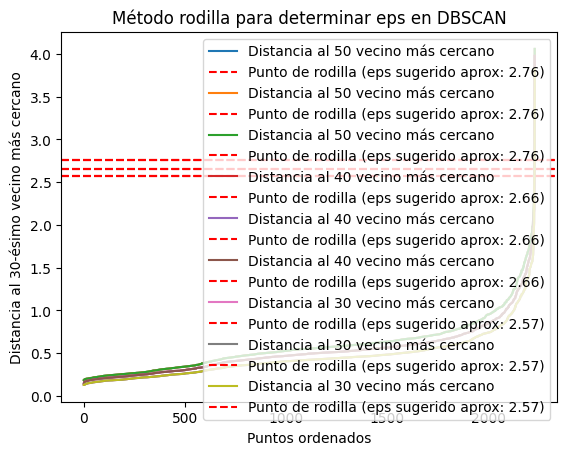

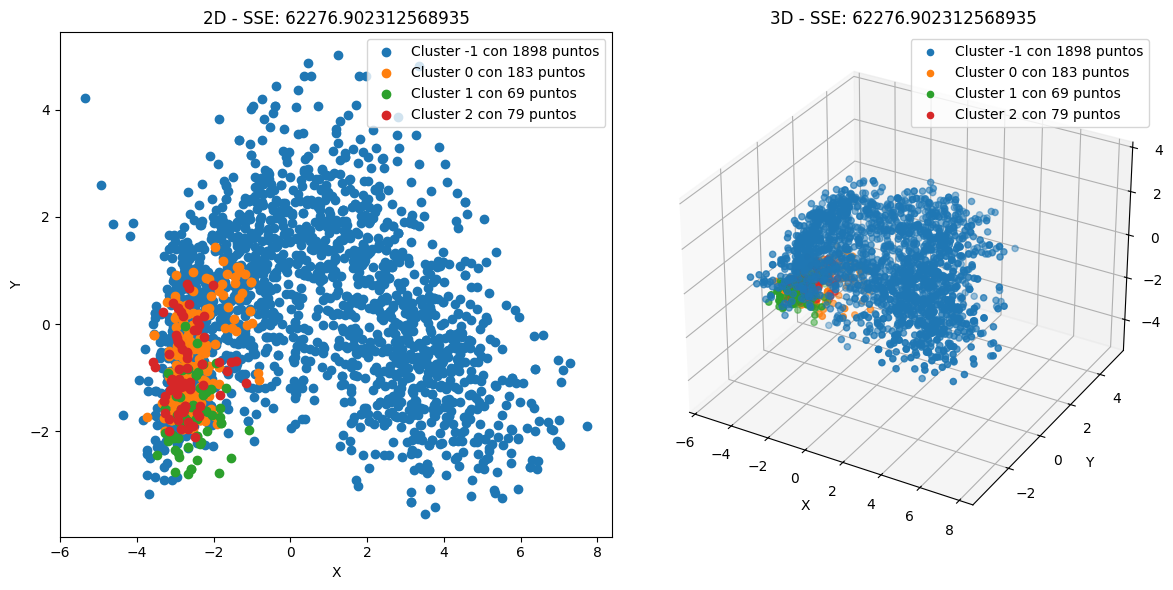

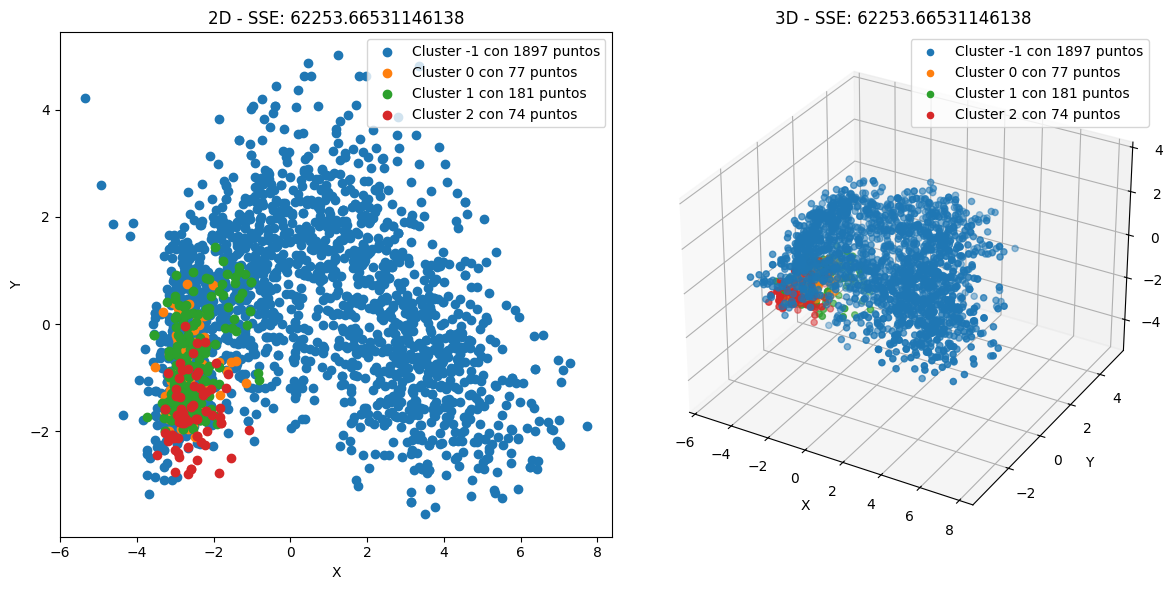

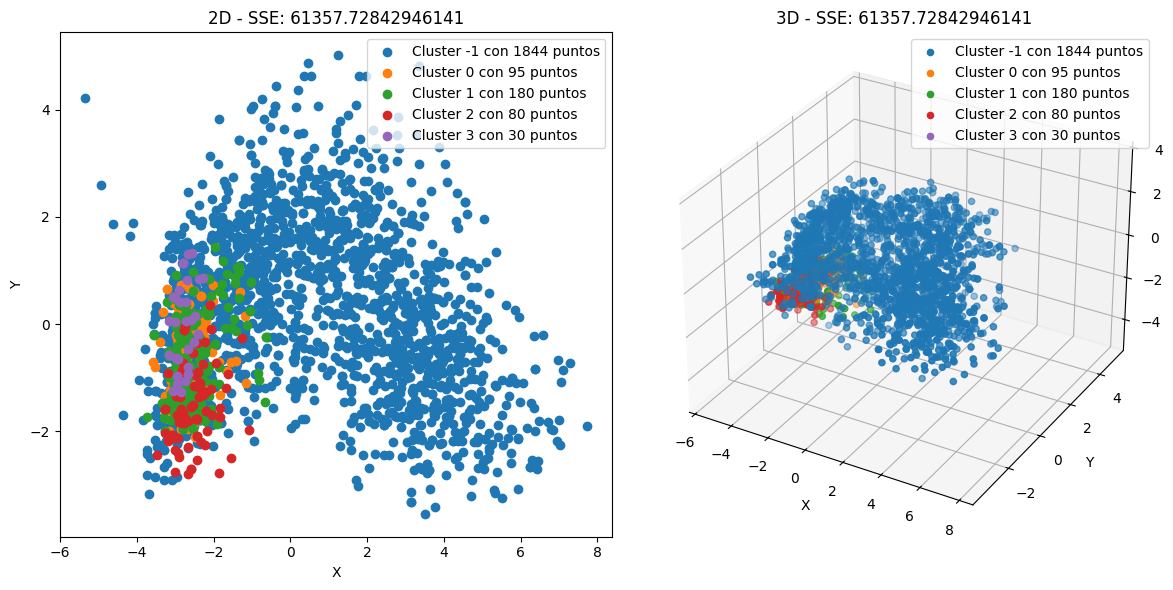

In [20]:
def plotClusters(D_2D, D_3D, C, sse):
  x = np.unique(C)

  fig = plt.figure(figsize=(12, 6))
  ax_2d = fig.add_subplot(121)
  ax_3d = fig.add_subplot(122, projection='3d')

  ax_2d.set_xlabel('X')
  ax_2d.set_ylabel('Y')


  ax_3d.set_xlabel('X')
  ax_3d.set_ylabel('Y')
  ax_3d.set_zlabel('Z')

  for ci in x:
    f = np.where(C == ci)[0]
    num_points = np.sum(C == ci)

    ax_3d.scatter(D_3D[f, 0], D_3D[f, 1], D_3D[f, 2], label=f'Cluster {ci} con {num_points} puntos')
    ax_2d.scatter(D_2D[f, 0], D_2D[f, 1], label=f'Cluster {ci} con {num_points} puntos')

  ax_2d.legend()
  ax_2d.set_title(f'2D - SSE: {sse}')

  ax_3d.legend()
  ax_3d.set_title(f'3D - SSE: {sse}')

  plt.tight_layout()
  plt.show()


min_samples_values = [50, 40, 30]
df_normalized = pd.DataFrame(StandardScaler().fit_transform(clients), columns=clients.columns)
dbscan_configs = zip(getEpsilons(min_samples_values), min_samples_values)
sse_values = []


for i, config in enumerate(dbscan_configs):
  eps, minpts = config
  clusters = DBSCAN(eps=eps, min_samples=minpts).fit_predict(df_normalized)

  if len(set(clusters)) > 1:
      distances = getDistances(df_normalized)
      centroids = np.array([np.mean(df_normalized[clusters == label], axis=0) for label in set(clusters)])
      sse = calculate_sse(df_normalized.values, clusters, centroids)
  else:
      sse = 0
      
      
  plotClusters(clients_2D,clients_3D, clusters, sse)

plt.show()


In [21]:
def getW(D, U, V):
    sum_weights = 0
    
    for i in U:
        for j in V:
            sum_weights += D[i, j]
    return sum_weights
def getWIn(D, C):
    clusters = np.unique(C)
    Win = 0
    
    for cluster in clusters:
        indices = np.where(C == cluster)[0]
        Win += getW(D, indices, indices)  
    return Win / 2
 
def getWOut(D, C):
    clusters = np.unique(C)
    Wout = 0

    for i, cluster_i in enumerate(clusters):
        for cluster_j in clusters[i + 1:]: 
            indices_i = np.where(C == cluster_i)[0]
            indices_j = np.where(C == cluster_j)[0]
            Wout += getW(D, indices_i, indices_j)
    return Wout

def getNIn(C):
    clusters = np.unique(C)
    Nin = 0

    for cluster in clusters:
        n = np.sum(C == cluster, axis=0) 
        Nin += n * (n - 1) / 2  
    return Nin
 
def getNOut(C):
    clusters = np.unique(C)
    Nout = 0

    for cluster in clusters:
        indices = np.where(C == cluster)[0]  
        n_cluster = len(indices)  
        n_other_clusters = len(np.where(C != cluster)[0])  
        Nout += (n_cluster * n_other_clusters) / 2  
    return Nout

In [22]:
def getBetaCVPlot(Win, Wout, Nin, Nout):
    return (Win / Nin) / (Wout / Nout)

def getCIndexPlot(D, Win, Nin):
    upper_diagonal = []
    for i in range(len(D)):
        for j in range( i + 1, len(D)):
            upper_diagonal.append(D[i][j])
    
    Wmin = np.sum(np.sort(upper_diagonal)[:int(Nin)])
    Wmax = np.sum(np.sort(upper_diagonal)[::-1][:int(Nin)])

    return (Win - Wmin) / (Wmax - Wmin)

def getNormalizedCutPlot(D, C):
    Nc = 0
    for cluster in np.unique(C):
        inside_indices = np.where(C == cluster)[0]
        outside_indices = np.where(C != cluster)[0]
        cluster_weight = np.sum(D[np.ix_(inside_indices, outside_indices)])
        cluster_volume = np.sum(D[inside_indices, :][:, inside_indices])
        Nc += cluster_weight / cluster_volume
    return Nc

def getDunnPlot(D, C):
    clusters = np.unique(C)
    min_intercluster = np.inf
    max_intracluster = 0
    for cluster_i in clusters:
        indices_i = np.where(C == cluster_i)[0]
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                indices_j = np.where(C == cluster_j)[0]
                intercluster_distances = D[np.ix_(indices_i, indices_j)]
                min_intercluster = min(min_intercluster, np.min(intercluster_distances))
        intracluster_distances = D[np.ix_(indices_i, indices_i)]
        max_intracluster = max(max_intracluster, np.max(intracluster_distances))
    return min_intercluster / max_intracluster

def getDaviesBouldinPlot(A, C):
    clusters = np.unique(C)
    S = np.zeros(len(clusters))
    centroids = np.zeros((len(clusters), A.shape[1]))
    for i, cluster in enumerate(clusters):
        points = A[C == cluster]
        centroids[i] = np.mean(points, axis=0)
        S[i] = np.mean(np.linalg.norm(points - centroids[i], axis=1))
    Rij = np.zeros((len(clusters), len(clusters)))
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            Rij[i, j] = Rij[j, i] = (S[i] + S[j]) / np.linalg.norm(centroids[i] - centroids[j])
    max_Rij = np.max(Rij, axis=1)
    DB_index = np.mean(max_Rij)
    return DB_index

    
def getSilhouettePlot(D, C):
    clusters = np.unique(C)

    silhouette_values = []
    for cluster in clusters: 
        indices = np.where(C == cluster)[0]
        for i in indices:
            Uin = np.mean([D[i, j] for j in indices if j != i])
            Uminout = np.inf
            for cluster_j in clusters:
                if cluster_j != cluster:
                    indices_j = np.where(C == cluster_j)[0]
                    mean_out = np.mean([D[i, j] for j in indices_j])
                    if mean_out < Uminout:
                        Uminout = mean_out            
            s_i = (Uminout - Uin) / max(Uminout, Uin)
            silhouette_values.append(s_i)
    return np.mean(silhouette_values)


In [23]:
def getMetricPlot(D, distances, clustering, metric, Win, Wout, Nin, Nout):
    if metric == "beta":
      return getBetaCVPlot(Win, Wout, Nin, Nout) 
    elif metric == "cindex":
      return getCIndexPlot(distances, Win, Nin)
    elif metric == "nc":
      return getNormalizedCutPlot(distances, clustering)
    elif metric == "dunn":
      return getDunnPlot(distances, clustering)
    elif metric == "db":
      return getDaviesBouldinPlot(D, clustering)
    elif metric == "sil":
      return getSilhouettePlot(distances, clustering)
    else:
      None

In [24]:
def plotMetrics(D, l, kmeans_eps, dbscan_configs, k_values):
    if isinstance(D, pd.DataFrame):
        D = D.values
    
    metrics = ['beta', 'cindex', 'nc', 'dunn', 'db', 'sil']
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.flatten()

    colores = ['red', 'blue', 'green']
    distances = getDistances(D)

    for i, metric in enumerate(metrics):
        print(i,metric)
        kmeans_results = []
        dbscan_results = []

        for k in k_values:
            kmeans_values = []
            for p in range(l):
                clustering, mu = kMeans(D, k, kmeans_eps,mu=None, max_iter=20)
                                
                Win = getWIn(distances, clustering)
                Wout = getWOut(distances, clustering)
                Nin = getNIn(clustering)
                Nout = getNOut(clustering)
                
                kmeans_values.append(getMetricPlot(D, distances, clustering, metric, Win, Wout, Nin, Nout))
            kmeans_results.append(kmeans_values)

        for config in dbscan_configs:
            minpts, eps = config
            clusteringDB= DBSCAN(eps=eps, min_samples=minpts).fit_predict(D)
            dbscan_results.append(getMetricPlot(D, distances,clusteringDB, metric, Win, Wout, Nin, Nout))

       
        axs[i].boxplot(kmeans_results, labels=k_values)
        axs[i].set_title(metric)
        axs[i].set_xlabel('k')
        axs[i].set_ylabel(metric)

        
        for result, config in zip(dbscan_results, dbscan_configs):
            axs[i].axhline(y=result, color=colores[dbscan_configs.index(config)], linestyle='--', label=f'DBScan {config}')

        axs[i].legend()

    plt.tight_layout()
    plt.show()

0 beta
1 cindex
2 nc
3 dunn
4 db
5 sil


C:\Users\sagr2\AppData\Local\Temp\ipykernel_15920\4139661389.py:72: RuntimeWarning: invalid value encountered in scalar divide
  s_i = (Uminout - Uin) / max(Uminout, Uin)
C:\Users\sagr2\AppData\Local\Temp\ipykernel_15920\4139661389.py:72: RuntimeWarning: invalid value encountered in scalar divide
  s_i = (Uminout - Uin) / max(Uminout, Uin)
C:\Users\sagr2\AppData\Local\Temp\ipykernel_15920\4139661389.py:72: RuntimeWarning: invalid value encountered in scalar divide
  s_i = (Uminout - Uin) / max(Uminout, Uin)


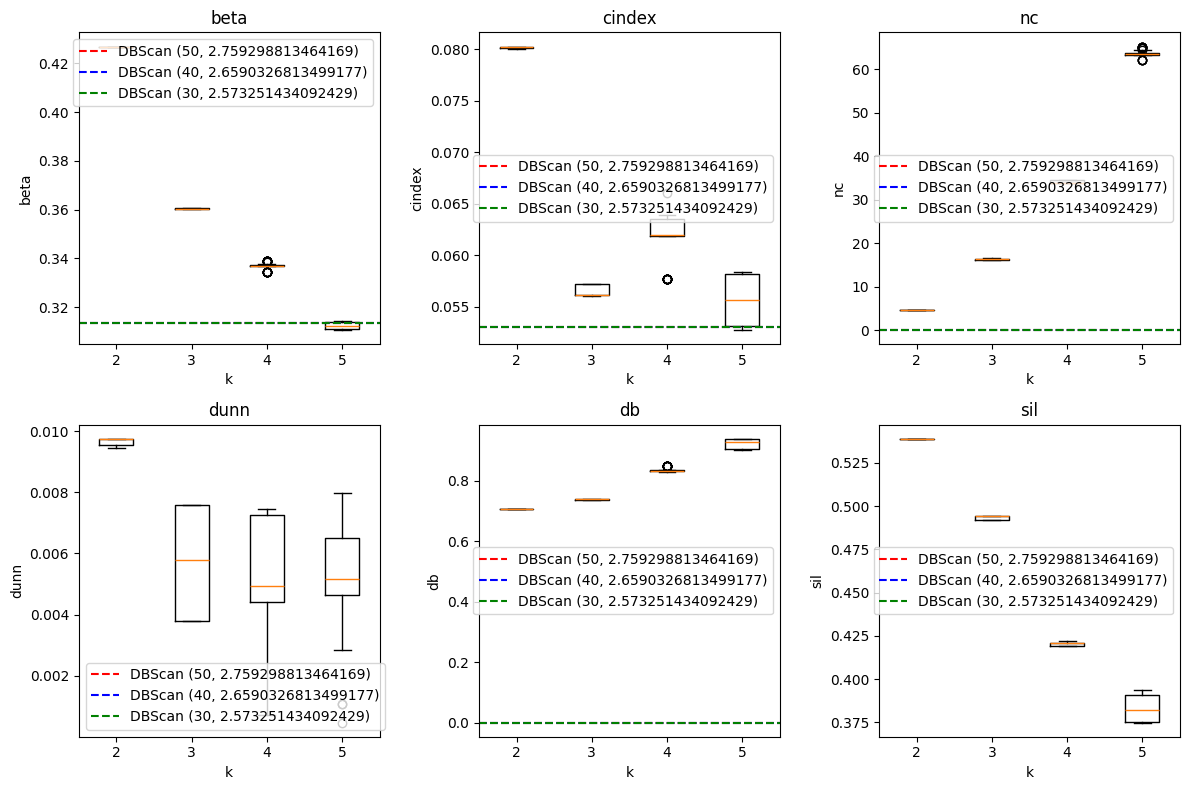

In [25]:
dbscan_configs_iris = [(50, 2.759298813464169),(40, 2.6590326813499177),(30, 2.573251434092429)]
k_values = [2, 3, 4, 5]
plotMetrics(clients_2D, l=50, kmeans_eps=0.01, dbscan_configs=dbscan_configs_iris, k_values = k_values)